In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
import warnings
from matplotlib.lines import Line2D
import scipy.stats
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

from IPython.display import HTML
config = dict(server='ABR-RIPLEYA-D1',
    port=      1433,
    database=  'boydcartridgePQ2022',
    )

conn_str = ('SERVER={server};' +
            'Database={database};' +
            'TRUSTED_CONNECTION=yes')

conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    conn_str.format(**config)
    )

In [2]:
colorDict  = {1:'#FF0000',#Red 1
              2:'#00B050',#Green 2
              3:'#0070C0',#Blue 3
              4:'#7030A0',#Purple 4
              5:'#808080',#Light Grey 5
              6:'#FF6600',#Orange 6
              7:'#FFCC00',#Yellow 7
              8:'#9999FF',#Light Purple 8
              9:'#333333',#Black 9
              10:'#808000',#Goldish 10
              11:'#FF99CC',#Hot Pink 11
              12:'#003300',#Dark Green 12
            }


def getSQLData_Channel(color, dtype, assay, start_time_filter, end_date_filter,system,assay_version,cartridge_lot_filter, cartridge_lot_filter_b, cartridge_lot_filter_c, cartridge_lot_filter_d):
    query = ("Select * from [dbo].[NeuMoDx_"+color+"_"+dtype+"_Master]"+
             "where ([Result Code] like '%"+assay+"%') and [Start Time]>'"+start_time_filter+"'"+
             " and [Start Time] < '"+end_date_filter+"' and [N500 Serial Number] like '%"+system+"%'"+
             " and [Assay Version] like '%"+assay_version+
             "%' and ([Cartridge Barcode] like '%"+cartridge_lot_filter+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_b+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_c+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_d+"%')")
    print("Query:", query)
    
    
    df = pd.read_sql(query, conn)
    ##Add Prefix Column
    df['Sample Prefix'] = df['Sample ID'].str[0]
    return df
             
def getSQLData_COC(assay, start_time_filter, end_date_filter, system, assay_version, cartridge_lot_filter, cartridge_lot_filter_b, cartridge_lot_filter_c, cartridge_lot_filter_d):
    query = ("Select * from [dbo].[NeuMoDx_System_Master_Table]"+
             " where ([Assay Name] like '%"+assay+"%') and [Start Date Time]>'"+start_time_filter+"'"+
             " and [Start Date Time] < '"+end_date_filter+"' and [N500 Serial Number] like '%"+system+"%'"+
             " and [Assay Version] like '%"+assay_version+"%' and ([Pcr Cartridge Barcode] like '%"+cartridge_lot_filter+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_b+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_c+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_d+"%')")
    print("Query:", query)
    df = pd.read_sql(query, conn)
    
    return df.set_index(['PCR Module Serial', 'Pcr Cartridge Lane'])


NormDataDict_PCR = {}
RawDataDict_PCR = {}
SecondDataDict_PCR = {}
COC_PCR = getSQLData_COC('GBS', '2022-03-28', '2022-12-31', '', '', '', '117', '117', '117').drop_duplicates(subset=['Test Guid'])

for channel in ['Green','Yellow']:
    NormDataDict_PCR[channel] = getSQLData_Channel(channel,'Normalized','GBS', '2022-03-28', '2022-12-31', '', '', '', '117', '117', '117').drop_duplicates(subset=['Test Guid'])
    RawDataDict_PCR[channel] = getSQLData_Channel(channel,'Raw', 'GBS', '2022-03-28', '2022-12-31', '', '', '', '117', '117', '117').drop_duplicates(subset=['Test Guid'])
    SecondDataDict_PCR[channel]= getSQLData_Channel(channel,'2nd','GBS', '2022-03-28', '2022-12-31', '', '', '', '117', '117', '117').drop_duplicates(subset=['Test Guid'])
    NormDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane', 'Test Guid'],inplace=True)
    RawDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane',  'Test Guid'],inplace=True)
    SecondDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane',  'Test Guid'],inplace=True)
    NormDataDict_PCR[channel].sort_index(inplace=True)

Query: Select * from [dbo].[NeuMoDx_System_Master_Table] where ([Assay Name] like '%GBS%') and [Start Date Time]>'2022-03-28' and [Start Date Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Pcr Cartridge Barcode] like '%%' OR [Pcr Cartridge Barcode] like '%117%' OR [Pcr Cartridge Barcode] like '%117%' OR [Pcr Cartridge Barcode] like '%117%')
Query: Select * from [dbo].[NeuMoDx_Green_Normalized_Master]where ([Result Code] like '%GBS%') and [Start Time]>'2022-03-28' and [Start Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Cartridge Barcode] like '%%' OR [Cartridge Barcode] like '%117%' OR [Cartridge Barcode] like '%117%' OR [Cartridge Barcode] like '%117%')
Query: Select * from [dbo].[NeuMoDx_Green_Raw_Master]where ([Result Code] like '%GBS%') and [Start Time]>'2022-03-28' and [Start Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Cartridge Barcode] like '

In [3]:
##Returns Consumable Information for each module included in Dataset Takes Chain of Custody Data as input
def generateLotTable(data):
    LotDataBase = data.sort_values('Start Date Time')

    #stats = ['Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']
    #results_Stats = ['Amp','NotAmp','NoResult','Sample Size']
    #LotDataBase['Run Number'] = np.nan
    for mod in LotDataBase.index.unique(0):
        LotDataBase.loc[mod, 'Time Difference'] = LotDataBase.loc[mod, 'Start Date Time'].diff().values / np.timedelta64(1, 's')
        LotDataBase.loc[mod, 'Time Difference'] = np.where(LotDataBase.loc[mod, 'Time Difference'].isnull(),50000,LotDataBase.loc[mod, 'Time Difference'])
        LotDataBase.loc[mod, 'New Run?'] = np.where(LotDataBase.loc[mod, 'Time Difference']>3600,True,False) 
        LotDataBase.loc[(mod, (LotDataBase['New Run?']==1)), 'Run Number'] = np.arange(1, len(LotDataBase.loc[mod, LotDataBase['New Run?']==1,:])+1)
        LotDataBase.loc[mod,['Run Number','Start Date Time','Time Difference','New Run?']] = LotDataBase.loc[mod,['Run Number','Start Date Time','Time Difference','New Run?']].fillna(method='ffill').values

    LotDataBase.reset_index(inplace=True)
    LotDataBase['Date'] = LotDataBase['Start Date Time'].dt.date
    LotDataBase.set_index(['PCR Module Serial', 'Run Number', 'Date'],inplace=True)
    LotDataBase['Cartridge Lot'] = LotDataBase['Pcr Cartridge Barcode'].str[18:24]
    LotDataBase['Cartridge Serial'] = LotDataBase['Pcr Cartridge Barcode'].str[27:32]
    LotDataBase['Test Strip Lot'] = LotDataBase['Test Strip NeuMoDx Barcode'].str[18:24]
    LotDataBase['LDT Master Mix Lot'] = LotDataBase['Test Strip LDT Master Mix Barcode'].str[18:24]
    LotDataBase['Extraction Plate Lot'] = LotDataBase['Capture Plate Barcode'].str[18:24]
    LotDataBase['Buffer Lot'] = LotDataBase['Buffer Barcode'].str[18:24]                                                 
    LotDataBase['Release Lot'] = LotDataBase['Release Reagent Barcode'].str[18:24]
    LotDataBase['Wash Lot'] = LotDataBase['Wash Reagent Barcode'].str[18:24]
    


    Lots = ['Cartridge Lot', 'Cartridge Serial', 'Test Strip Lot', 'Extraction Plate Lot', 'Buffer Lot', 'Release Lot',  'Wash Lot', 'Result Code']
    #display(LotDataBase['LotDataBase Strip Lot'].groupby(level=[0,1]).agg('unique'))
    LotDataBase_aggs = {}
    for lot_type in Lots:
        LotDataBase_by_run_agg = LotDataBase[lot_type].groupby(level=[0,1,2]).agg('unique').to_frame()
        LotDataBase_by_mod_agg = LotDataBase[lot_type].groupby(level=[0]).agg('unique').to_frame()
        LotDataBase_by_date_agg = LotDataBase[lot_type].groupby(level=[2]).agg('unique').to_frame()
        #LotDataBase_by_date_agg = LotDataBase[lot_type].groupby(level=[2]).agg('unique').to_frame()    

        LotDataBase_by_mod_agg['Run Number'] = 'Combined'
        LotDataBase_by_mod_agg['Date'] = 'Combined'
        
        LotDataBase_by_date_agg['Run Number'] = 'Combined'
        LotDataBase_by_date_agg['PCR Module Serial'] = 'Combined'
        
        LotDataBase_by_mod_agg.set_index(['Run Number','Date'],append=True,inplace=True)
        LotDataBase_by_date_agg.set_index(['Run Number', 'PCR Module Serial'],append=True,inplace=True)
        LotDataBase_by_date_agg = LotDataBase_by_date_agg.reorder_levels(['PCR Module Serial', 'Run Number', 'Date'],axis=0)
        LotDataBase_agg = pd.concat([LotDataBase_by_run_agg,LotDataBase_by_mod_agg,LotDataBase_by_date_agg],axis=0).sort_index()
        #LotDataBase_agg.sort_index(axis=1,inplace=True)
        #LotDataBase_agg.set_index('Ct Calls',append=True,inplace=True)
        LotDataBase_aggs[lot_type] = LotDataBase_agg
    consumables = pd.concat([LotDataBase_aggs[x] for x in LotDataBase_aggs],axis=1)
    consumables.index.names = ['XPCR Module Serial', 'Run Number','Date']
    consumables.columns = pd.MultiIndex.from_tuples([(lot, '', '') for lot in consumables.columns])
    return consumables, LotDataBase[Lots+['Test Guid', 'LHPA ADP Position', 'LHPB ADP Position', 'LHPC ADP Position', 'Pcr Cartridge Lane']]

##Returns By Run Summary Information & Run Labeled Line Data for each module included in Dataset Takes Channel Data as input
def generateSummaryTable(data, channel):
    SummaryDataBase = data.sort_values('Start Time')

    stats = ['Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']
    results_Stats = ['Amp','NotAmp','NoResult','IND', 'UNR', 'Sample Size']
    #SummaryDataBase['Run Number'] = np.nan
    for mod in SummaryDataBase.index.unique(0):
        SummaryDataBase.loc[mod, 'Time Difference'] = SummaryDataBase.loc[mod, 'Start Time'].diff().values / np.timedelta64(1, 's')
        SummaryDataBase.loc[mod, 'Time Difference'] = np.where(SummaryDataBase.loc[mod, 'Time Difference'].isnull(),50000,SummaryDataBase.loc[mod, 'Time Difference'])
        SummaryDataBase.loc[mod, 'New Run?'] = np.where(SummaryDataBase.loc[mod, 'Time Difference']>3600,True,False) 
        SummaryDataBase.loc[(mod, (SummaryDataBase['New Run?']==1)), 'Run Number'] = np.arange(1, len(SummaryDataBase.loc[mod, SummaryDataBase['New Run?']==1,:])+1)
        SummaryDataBase.loc[mod,['Run Number','Start Time','Time Difference','New Run?']] = SummaryDataBase.loc[mod,['Run Number','Start Time','Time Difference','New Run?']].fillna(method='ffill').values

    SummaryDataBase['NotAmp'] = np.where(SummaryDataBase['Target Result']=='TargetNotAmplified',1,0)
    SummaryDataBase['Amp'] = np.where(SummaryDataBase['Target Result']=='TargetAmplified',1,0)
    SummaryDataBase['NoResult'] = np.where(SummaryDataBase['Target Result']=='NoResult',1,0)
    SummaryDataBase['IND'] = np.where(SummaryDataBase['Target Result']=='TargetIndeterminate',1,0)
    SummaryDataBase['UNR'] = np.where(SummaryDataBase['Target Result']=='TargetUnresolved',1,0)
    SummaryDataBase['Abort'] = np.where(SummaryDataBase['Target Result']=='TargetAborted',1,0)
    SummaryDataBase['Sample Size'] = SummaryDataBase[['NotAmp','Amp','NoResult','IND','UNR']].sum(axis=1)

    SummaryDataBase.loc[:,['NotAmp','Amp','IND','UNR','NoResult','Sample Size']]



    SummaryDataBase.reset_index(inplace=True)
    SummaryDataBase.set_index(['XPCR Module Serial','Run Number'],inplace=True)
    SummaryDataBase.loc[:,stats] =  SummaryDataBase.loc[:,stats].astype(float)

    SummaryDataBase.to_csv('SummaryDataBase.csv')

    agg_dict = {}
    agg_dict['Start Time'] = ['first','last']
    for stat in results_Stats:
        agg_dict[stat] = ['sum']
    for stat in stats:
        agg_dict[stat] = ['mean','std','count']
    agg_dict

    SummaryDataBase_by_run_agg = SummaryDataBase[stats+results_Stats+['Start Time']].groupby(level=[0,1]).agg(agg_dict)



    SummaryDataBase_by_mod_agg = SummaryDataBase[stats+results_Stats+['Start Time']].groupby(level=[0]).agg(agg_dict)


    SummaryDataBase_by_mod_agg['Run Number'] = 'Combined'
    SummaryDataBase_by_mod_agg.set_index('Run Number',append=True,inplace=True)

    SummaryDataBase_agg = pd.concat([SummaryDataBase_by_run_agg,SummaryDataBase_by_mod_agg],axis=0).sort_index()

    SummaryDataBase_agg[('Ct Calls','')] = SummaryDataBase_agg[('Ct','count')]
    for param in SummaryDataBase_agg.columns.unique(0):
        if param in stats:
            SummaryDataBase_agg[(param, '%CV')] = SummaryDataBase_agg[(param, 'std')] / SummaryDataBase_agg[(param, 'mean')]
            SummaryDataBase_agg.drop([(param,'count')],axis=1,inplace=True)
    SummaryDataBase_agg.sort_index(axis=1,inplace=True)
    SummaryDataBase_agg.set_index('Ct Calls',append=True,inplace=True)
    SummaryDataBase_agg.columns = pd.MultiIndex.from_tuples([(channel,x,y) for x,y in SummaryDataBase_agg.columns])
    SummaryDataBaseagg = SummaryDataBase_agg.loc[:,channel]
    SummaryDataBaseagg[('% Amp', '')] = SummaryDataBaseagg[('Amp', 'sum')] / (SummaryDataBaseagg[('Amp', 'sum')] + SummaryDataBaseagg[('NotAmp', 'sum')])
    SummaryDataBaseagg = SummaryDataBaseagg.loc[:,['Start Time', '% Amp', 'Amp','NotAmp','NoResult', 'IND', 'UNR', 'Sample Size', 'Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']].droplevel(2,axis=0)
    SummaryDataBaseagg.columns = pd.MultiIndex.from_tuples([('Start Time', 'first sample'),
                                                 ('Start Time', 'last sample'),
                                                 ('% AMP', ''),
                                                 ('Amp', '') ,
                                                 ('NotAmp', '') ,
                                                 ('NoResult', ''),
                                                 ('UNR', '') ,
                                                 ('IND', '') ,
                                                 ('Sample Size', ''),
                                                 ('Ct', '%CV') ,
                                                 ('Ct', 'mean') ,
                                                 ('Ct', 'std') ,
                                                 ('End Point Fluorescence', '%CV') ,
                                                 ('End Point Fluorescence', 'mean') ,
                                                 ('End Point Fluorescence', 'std'),
                                                 ('Max Peak Height', '%CV') ,
                                                 ('Max Peak Height', 'mean') ,
                                                 ('Max Peak Height', 'std') ,
                                                 ('EPR', '%CV') ,
                                                 ('EPR', 'mean') ,
                                                 ('EPR', 'std')])
    return SummaryDataBaseagg, SummaryDataBase

In [4]:
COC_PCR = COC_PCR.loc[([x for x in COC_PCR.index.unique(0) if pd.isnull(x)==False],
                       [x for x in COC_PCR.index.unique(1) if pd.isnull(x)==False]),:]

#DF = generateLotTable(COC_PCR).join(generateSummaryTable(RawDataDict_PCR['Yellow'],'Yellow'))
channelData = {}    

channelData['Green'] = generateSummaryTable(RawDataDict_PCR['Green'], 'Green')

channelData['Yellow'] =  generateSummaryTable(RawDataDict_PCR['Yellow'], 'Yellow')


consumables = generateLotTable(COC_PCR)
#channelData['Green'][0].loc[mods]

In [5]:
##Step 1A Get Consumables used for Testing By Date.
display(HTML(consumables[0].loc[([x for x in consumables[0].index.unique(0) if x == 'Combined'],[y for y in consumables[0].index.unique(1) if y == 'Combined']),:].reset_index()\
     .style.hide_index()\
     .to_html()))

##Step 1B Get Consumables used for Testing By Module.
display(HTML(consumables[0].loc[([x for x in consumables[0].index.unique(0) if x != 'Combined'],[y for y in consumables[0].index.unique(1) if y == 'Combined']),:].reset_index()\
     .style.hide_index()\
     .to_html()))

##Step 1C Get Consumables used for Testing By Module Run.
display(HTML(consumables[0].loc[(slice(None),[x for x in consumables[0].index.unique(1) if x != 'Combined']),:].reset_index()\
     .style.hide_index()\
     .format(subset=['Run Number'], formatter='{:.0f}')\
     .to_html()))

XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
Combined,Combined,2022-03-29,['118522'],['01698' '01779' '01769' '01799' '01696' '01699' '01771' '01693' '01780' '01773' '01697' '01692' '01774' '01700' '01778' '01781' '01695' '01770' '01694' '01772' '01798' '01701' '01806' '01807' '01711' '03103' '03472' '03440' '03464' '03469' '03436' '03465' '03466' '03398' '03439' '03265' '03470' '03467' '03277' '03102' '03405' '03441' '03468' '03437' '03471' '03438' '03463' '03443' '03442' '03422' '03421' '01712' '01713'],['11857X' ''],['113599' '118151' '118150' '113600' '113643'],['115887'],['113222' '117866'],['113945' '113942'],['GBS']
Combined,Combined,2022-04-06,['118705'],['00625' '00626' '00094' '00628' '00101' '00093' '00096' '00627' '00090' '00098' '00095' '00097' '00438' '00092' '00091' '00439' '06360' '06356' '00180' '06358' '06364' '00071' '00075' '06357' '00074' '06365' '00181' '00070' '00073' '00629' '00069' '00072'],['11857X'],['113599' '118150' '118151' '113600' '113547'],['115887' '117157'],['113222' '117867'],['113942' '113945'],['GBS']
Combined,Combined,2022-04-07,['118705'],['06424' '06361' '06499' '06501' '06494' '06500' '06502' '06362' '06496' '06425' '06359' '06498' '06497' '06485' '06363' '06495' '06438' '06469' '06470' '06439'],['11857X'],['113599'],['117157' '115887'],['113222' '117866'],['113945' '113942'],['GBS']


XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
V1039,Combined,Combined,['118522'],['01770' '03438'],['11857X'],['113599'],['115887'],['113222'],['113945'],['GBS']
V1108,Combined,Combined,['118522' '118705'],['01772' '03468' '06363' '06439'],['11857X'],['113599'],['115887' '117157'],['117866'],['113942'],['GBS']
V1111,Combined,Combined,['118522'],['01780' '03436' '03421'],['11857X'],['118150' '118151' '113599'],['115887'],['113222'],['113945'],['GBS']
V1119,Combined,Combined,['118522'],['01779' '03440'],['11857X'],['113599'],['115887'],['113222'],['113945'],['GBS']
V132,Combined,Combined,['118522'],['01778' '03441'],['11857X'],['113599'],['115887'],['113222'],['113945'],['GBS']
V29,Combined,Combined,['118705'],['00439' '00069' '06359'],['11857X'],['118150' '113600' '113547' '113599'],['117157'],['113222'],['113945'],['GBS']
V30,Combined,Combined,['118522' '118705'],['01692' '03467' '06502'],['11857X'],['113599'],['115887'],['113222'],['113945'],['GBS']
V42,Combined,Combined,['118522' '118705'],['01798' '03437' '01713' '00091' '00070' '06425'],['11857X'],['118151' '118150' '113599' '113600' '113547'],['115887' '117157'],['113222'],['113945'],['GBS']


XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
V1039,1,2022-03-29,['118522'],['01770'],['11857X'],['113599'],['115887'],['113222'],['113945'],['GBS']
V1039,2,2022-03-29,['118522'],['03438'],['11857X'],['113599'],['115887'],['113222'],['113945'],['GBS']
V1108,1,2022-03-29,['118522'],['01772'],['11857X'],['113599'],['115887'],['117866'],['113942'],['GBS']
V1108,2,2022-03-29,['118522'],['03468'],['11857X'],['113599'],['115887'],['117866'],['113942'],['GBS']
V1108,3,2022-04-07,['118705'],['06363'],['11857X'],['113599'],['115887'],['117866'],['113942'],['GBS']
V1108,4,2022-04-07,['118705'],['06439'],['11857X'],['113599'],['117157'],['117866'],['113942'],['GBS']
V1111,1,2022-03-29,['118522'],['01780'],['11857X'],['118150' '118151'],['115887'],['113222'],['113945'],['GBS']
V1111,2,2022-03-29,['118522'],['03436'],['11857X'],['113599'],['115887'],['113222'],['113945'],['GBS']


In [6]:
##Generate 2 %Positivity Table for Positive and Negative values. 
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
positivityFrame = COC_PCR[['Test Guid', 'Sample ID', 'Overall Result', 'Pcr Cartridge Barcode','N500 Serial Number', 'Start Date Time', 'Test Strip NeuMoDx Barcode','Green Target Ct']]
positivityFrame['Sample Prefix'] = positivityFrame['Sample ID'].str[0] 
positivityFrame['Condition'] = np.where(positivityFrame['Sample Prefix']=='N','Negative','Positive') 

positivityFrame.drop_duplicates('Test Guid',inplace=True)
positivityFrame['Cartridge Lot'] = positivityFrame['Pcr Cartridge Barcode'].str[18:24]
positivityFrame['Test Strip Lot'] = positivityFrame['Test Strip NeuMoDx Barcode'].str[18:24]
positivityFrame['Cartridge Serial'] = positivityFrame['Pcr Cartridge Barcode'].str[27:32]
positivityFrame.set_index(['Condition','Cartridge Lot','Test Strip Lot','N500 Serial Number'],append=True,inplace=True)
positivityFrame.sort_index(inplace=True)

positivityFrame = positivityFrame.reorder_levels(['Condition', 'Cartridge Lot', 'Test Strip Lot', 'N500 Serial Number','PCR Module Serial','Pcr Cartridge Lane']).sort_index()

positivityFrame['Positive'] = np.nan
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Positive', 1, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Indeterminate', np.nan, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Unresolved', np.nan, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='NoResult', np.nan, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Negative', 0, positivityFrame['Positive'])

positivityFrame['Valid'] = np.nan
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Positive', 1, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Indeterminate', 0, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Unresolved', 0, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='NoResult', 0, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Negative', 1, positivityFrame['Valid'])
positivityFrame


positivityFrame = positivityFrame.loc[[x for x in positivityFrame.index.unique(0) if 'Exclude' not in x],:]
positivityFrame

displayFrame = positivityFrame[['Positive', 'Valid']].groupby(level=[0,1]).agg({'Positive':['mean','sum','count'],
                                                                          'Valid':['count']}).loc[:,:].droplevel(0,axis=1)

displayFrame.columns = ['% positive', 'positive count', 'valid samples', 'total samples']

##Get Number of Cartridges by creating a list of unique cartridges tested.
cartridge_counter = positivityFrame['Cartridge Serial'].groupby(level=[0,1]).agg('unique').to_frame()
for x in displayFrame.index:
    displayFrame.loc[x, '# of Cartridges Tested'] = len(cartridge_counter.loc[x, 'Cartridge Serial'])

displayFrame = displayFrame.loc[:,:]

for condition, cartridge in displayFrame.index:
    lcb, ucb = proportion_confint(count=displayFrame.loc[(condition, cartridge),'positive count'], nobs=displayFrame.loc[(condition, cartridge),'valid samples'], alpha=(1-0.95), method='beta')
    displayFrame.loc[(condition, cartridge), ['95% CI LCB', '95% CI UCB']] = [lcb, ucb]


displayFrame.columns = ['% Positive', 'Positive Count', 'Valid Samples', 'Total Samples', '# of Cartridges Tested', '95% CI LCB', '95% CI UCB']
displayFrame = displayFrame[['# of Cartridges Tested', 'Total Samples','Valid Samples', 'Positive Count',   '% Positive',  '95% CI LCB','95% CI UCB']]
display(displayFrame.loc[(slice(None), '118522'),:].style.format(subset=[x for x in displayFrame.columns if '%' in x], formatter='{:.2%}').format(subset=['Positive Count', '# of Cartridges Tested'], formatter='{:.0f}'))#.background_gradient(subset=[x for x in displayFrame.columns if '%' in x], cmap='RdYlGn_r',axis=0))

positivityFrame =positivityFrame.set_index('Cartridge Serial', append=True)
positivityFrame = positivityFrame.reorder_levels(['Condition', 'Cartridge Lot', 'Cartridge Serial', 'Test Strip Lot', 'N500 Serial Number','PCR Module Serial','Pcr Cartridge Lane']).sort_index()

positivityFrame['Positive'] = np.nan
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Positive', 1, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Indeterminate', np.nan, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Unresolved', np.nan, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='NoResult', np.nan, positivityFrame['Positive'])
positivityFrame['Positive'] = np.where(positivityFrame['Overall Result']=='Negative', 0, positivityFrame['Positive'])

positivityFrame['Valid'] = np.nan
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Positive', 1, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Indeterminate', 0, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Unresolved', 0, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='NoResult', 0, positivityFrame['Valid'])
positivityFrame['Valid'] = np.where(positivityFrame['Overall Result']=='Negative', 1, positivityFrame['Valid'])
positivityFrame


positivityFrame = positivityFrame.loc[[x for x in positivityFrame.index.unique(0) if 'Exclude' not in x],:]
#HTML(positivityFrame.reset_index().style.hide_index().to_html())

,,# of Cartridges Tested,Total Samples,Valid Samples,Positive Count,% Positive,95% CI LCB,95% CI UCB
Condition,Cartridge Lot,,,,,,,
Negative,118522,53,318,310,0,0.00%,0.00%,1.18%
Positive,118522,53,318,314,313,99.68%,98.24%,99.99%


In [7]:
##Step 3 Generate By Cartridge Serial Summary Table: 
cartridgeDescriptionFrame = positivityFrame[['Valid','Positive']].groupby(['Cartridge Lot', 'PCR Module Serial','Cartridge Serial','Condition']).agg(['count','sum','mean'])
cartridgeDescriptionFrame.columns = ['Total Samples', 'Valid Samples #', 'Valid Samples %', 'drop', 'Positive Samples #', 'Positive Samples %'] 
cartridgeDescriptionFrame.drop('drop',axis=1, inplace=True)                           
HTML(cartridgeDescriptionFrame.loc[('118705',slice(None)),:].style.format(subset=[x for x in cartridgeDescriptionFrame.columns if '#' in x], formatter="{:.0f}").format(subset=[x for x in cartridgeDescriptionFrame.columns if '%' in x], formatter="{:.2%}").to_html())
                                                            
                                                            

In [8]:
ColorDict48 = {1: '#FF0000',
              2: '#00B050',
              3: '#0070C0',
              4: '#7030A0',
              5: '#808080',
              6: '#FF6600',
              7: '#FFCC00',
              8: '#9999FF',
              9: '#333333',
              10: '#808000',
              11: '#FF99CC',
              12: '#003300',
              13: '#FF0000',
              14: '#00B050',
              15: '#0070C0',
              16: '#7030A0',
              17: '#808080',
              18: '#FF6600',
              19: '#FFCC00',
              20: '#9999FF',
              21: '#333333',
              22: '#808000',
              23: '#FF99CC',
              24: '#003300',
              25: '#FF0000',
              26: '#00B050',
              27: '#0070C0',
              28: '#7030A0',
              29: '#808080',
              30:'#FF6600',
              31: '#FFCC00',
              32: '#9999FF',
              33: '#333333',
              34: '#808000',
              35: '#FF99CC',
              36: '#003300',
              37: '#FF0000',
              38: '#00B050',
              39: '#0070C0',
              40: '#7030A0',
              41: '#808080',
              42: '#FF6600',
              43: '#FFCC00',
              44: '#9999FF',
              45: '#333333',
              46: '#808000',
              47: '#FF99CC',
              48: '#003300',}

In [9]:
StyleDict48 = {1: 'solid',
              2: 'solid',
              3: 'solid',
              4: 'solid',
              5: 'solid',
              6: 'solid',
              7: 'solid',
              8: 'solid',
              9: 'solid',
              10: 'solid',
              11: 'solid',
              12: 'solid',
              13: 'dashed',
              14: 'dashed',
              15: 'dashed',
              16: 'dashed',
              17: 'dashed',
              18: 'dashed',
              19: 'dashed',
              20: 'dashed',
              21: 'dashed',
              22: 'dashed',
              23: 'dashed',
              24: 'dashed',
              25: 'dashdot',
              26: 'dashdot',
              27: 'dashdot',
              28: 'dashdot',
              29: 'dashdot',
              30:'dashdot',
              31:'dashdot',
              32: 'dashdot',
              33: 'dashdot',
              34: 'dashdot',
              35: 'dashdot',
              36: 'dashdot',
              37: 'dotted',
              38: 'dotted',
              39: 'dotted',
              40: 'dotted',
              41: 'dotted',
              42:'dotted',
              43:'dotted',
              44: 'dotted',
              45: 'dotted',
              46: 'dotted',
              47: 'dotted',
              48: 'dotted',
              }

<Figure size 432x288 with 0 Axes>

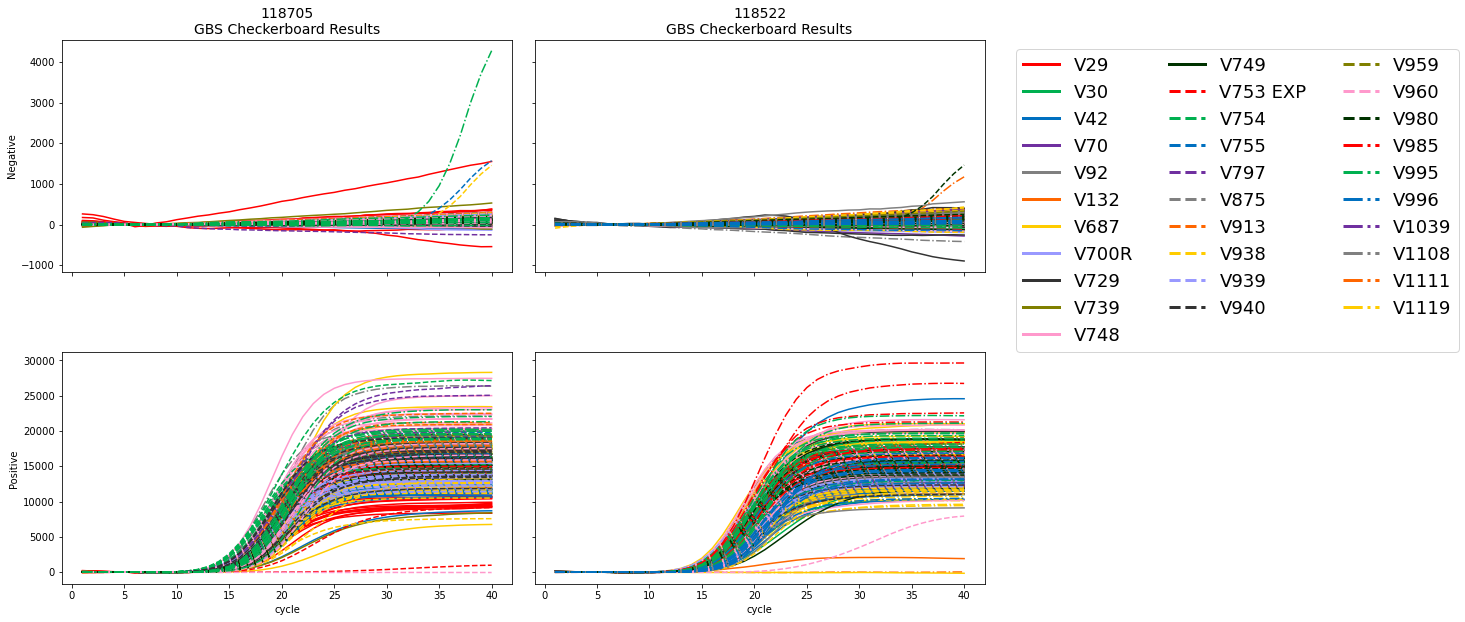

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


In [10]:
##Step 4: Plot Amplification Curves for All Samples Included in testing
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
##Define Modules to Include in Plots
mods = sorted(COC_PCR.index.unique(0).dropna().to_list(), key= lambda x: int(x.replace("V", "")\
                                                                             .replace("EXP", "")\
                                                                             .replace("R", "")))#Define Channels to Include in Plots

##Exclude samples by Test Guid
exclude_list = []

##Define Lots to Plot
lots = COC_PCR['Cartridge Lot'].unique().tolist()

#Define Channels to Plot
channels = ['Green', 'Yellow']

#Define Targets to Include in Plots
target_names = ['GBS', 'SPC1']

#Define Target / Channel Combinations
targets = {'Green':'GBS',
           'Yellow':'SPC1'}


channelData_Line = {}
amp_groups = ['Negative', 'Positive']

channelDataDict = {}
COC_PCR = COC_PCR.loc[([x for x in COC_PCR.index.unique(0) if pd.isnull(x)==False],
                       [x for x in COC_PCR.index.unique(1) if pd.isnull(x)==False]),:]

channelData = {}    
channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')
channelData['Yellow'] = generateSummaryTable(NormDataDict_PCR['Yellow'], 'Yellow')

for group in amp_groups:
    channelData_Line[group] = channelData['Green'][1].reset_index().set_index(['XPCR Module Serial', 'Run Number'])
    channelData_Line[group]['Sample Prefix'] = channelData_Line[group]['Sample ID'].str[0]
    channelData_Line[group]['Condition'] = np.where(channelData_Line[group]['Sample Prefix']=='N','Negative','Positive')
    channelData_Line[group] = channelData_Line[group].loc[channelData_Line[group]['Condition']==group].sort_index()



consumables = generateLotTable(COC_PCR)
plt.subplots_adjust(wspace=0.05)



fig, axs = plt.subplots(len(amp_groups), len(lots)+1, figsize=(25,10),sharey='row',sharex=True)
run_exclude_list = []
for channel in amp_groups:

    plt.subplots_adjust(wspace=0.05,hspace=0.35)
    channelData_Line[channel].loc[:,'Cartridge Lot'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[18:24]
    channelData_Line[channel].loc[:,'Cartridge Serial'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[28:32]
    channelData_Line[channel]['Cartridge Lot'].unique()

    
    channelplotdata = channelData_Line[channel]
    channelplotdata = channelplotdata[channelplotdata['Cartridge Lot']!='Cold Lam']
    channelplotdata = channelplotdata.loc[~channelplotdata['Test Guid'].isin(exclude_list),:]
    channelplotdata = channelplotdata.dropna(subset=['Condition'])
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)

    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot', 'Cartridge Serial', 'Condition'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Sample ID']]
    channelDataDict[channel] = channelDataDict[channel].reset_index().drop_duplicates(subset=['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition']).set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Cartridge Serial', 'Condition'])
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    

    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan, axis=0, inplace=True)

    channelplotdata.set_index('Test Guid', append=True, inplace=True)
    for mod, run, lane, guid in channelplotdata.index.unique():
        amp_group = channelplotdata.loc[(mod,run,lane,guid), 'Condition']
        if mod in mods:
            
            lot = channelplotdata.loc[(mod,run,lane,guid), 'Cartridge Lot']
            target = channelplotdata.loc[(mod,run,lane,guid), 'Target Name']


            if guid not in exclude_list and mod in mods:
                X = np.arange(1,41,1)
                Y = channelplotdata.loc[(mod,run,lane,guid), ['Readings '+str(read) for read in range(1,41,1)]]
                sns.lineplot(x=X,y=Y, color=ColorDict48[mods.index(mod)+1],linestyle=StyleDict48[mods.index(mod)+1],ax=axs[amp_groups.index(amp_group),lots.index(lot)])
                axs[0,lots.index(lot)].set_title(lot+"\nGBS Checkerboard Results",fontsize=14, color='k')#ColorDict48[treatments.index(treatment)+1])
    
    
       
for lot in lots:
    for amp_group in amp_groups:
        if amp_groups.index(amp_group) == len(amp_groups)-1:
                axs[amp_groups.index(amp_group),lots.index(lot)].set_xlabel('cycle')
        axs[amp_groups.index(amp_group),0].set_ylabel(amp_group)
            
    

legend_elements = []
for mod in mods:
    newLabel = Line2D([0], [0], color=ColorDict48[mods.index(mod)+1], linestyle=StyleDict48[mods.index(mod)+1], lw=3,label=mod)
    legend_elements.append(newLabel)

axs[0,len(lots)].legend(handles=legend_elements, fontsize=18,loc='upper left',ncol=3)

# for row in range(0,len(amp_groups)):
#     axs[row,0].invert_yaxis()
    


for row in range(0,len(amp_groups)):
    axs[row,len(lots)].axis('Off')
plt.show()
print("_ _"*30)
data = pd.concat([channelDataDict[df] for df in channelDataDict],axis=1).sort_index()

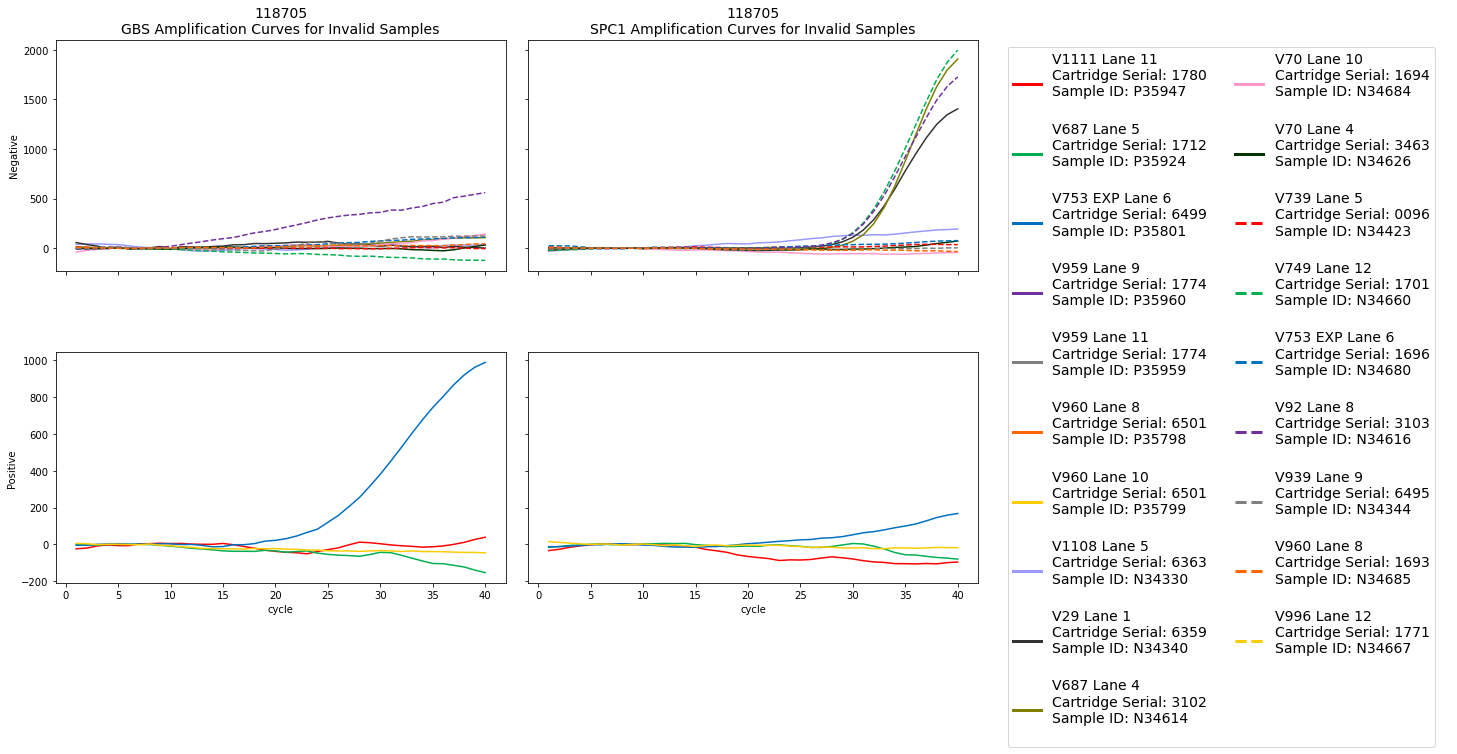

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


In [11]:
#Step 5 Plot Data for Invalid Samples Only
##Exclude samples by Test Guid
exclude_list = []

##Define Lots to Plot
lots = COC_PCR['Cartridge Lot'].unique().tolist()
COC_PCR.loc[:,'Cartridge Serial'] = COC_PCR.loc[:,'Pcr Cartridge Barcode'].str[28:32]


#Define Channels to Plot
channels = ['Yellow', 'Green']

#Define Targets to Include in Plots
target_names = ['GBS', 'SPC1']

#Define Target / Channel Combinations
targets = {'Green':'GBS',
           'Yellow':'SPC1'}


channelData_Line = {}
amp_groups = ['Negative', 'Positive']

channelDataDict = {}

samples = {}

channelData = {}
channelData_Line_Yellow = {}
channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')
channelData['Yellow'] = generateSummaryTable(NormDataDict_PCR['Yellow'], 'Yellow')

for group in amp_groups:
    channelData_Line[group] = channelData['Green'][1].reset_index().set_index(['XPCR Module Serial', 'Run Number'])
    channelData_Line[group]['Sample Prefix'] = channelData_Line[group]['Sample ID'].str[0]
    channelData_Line[group]['Condition'] = np.where(channelData_Line[group]['Sample Prefix']=='N','Negative','Positive')
    channelData_Line[group] = channelData_Line[group].loc[channelData_Line[group]['Condition']==group].sort_index()
    channelData_Line[group] = channelData_Line[group].loc[~channelData_Line[group]['Target Result'].isin(['TargetAmplified', 'TargetNotAmplified'])]
    samples[group] = channelData_Line[group]['Test Guid'].unique().tolist()

sampleList = samples['Positive'] + samples['Negative']
for group in amp_groups:
    channelData_Line_Yellow[group] = channelData['Yellow'][1].reset_index().set_index(['XPCR Module Serial', 'Run Number'])
    channelData_Line_Yellow[group]['Sample Prefix'] = channelData_Line_Yellow[group]['Sample ID'].str[0]
    channelData_Line_Yellow[group]['Condition'] = np.where(channelData_Line_Yellow[group]['Sample Prefix']=='N','Negative','Positive')
    channelData_Line_Yellow[group] = channelData_Line_Yellow[group].loc[channelData_Line_Yellow[group]['Condition']==group].sort_index()
    channelData_Line_Yellow[group] = channelData_Line_Yellow[group].loc[channelData_Line_Yellow[group]['Test Guid'].isin(samples[group])]
    


fig, axs = plt.subplots(2, len(channels)+1, figsize=(25,10),sharey='row',sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.35)

run_exclude_list = []
for channel in amp_groups:

    channelData_Line[channel].loc[:,'Cartridge Lot'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[18:24]
    channelData_Line[channel].loc[:,'Cartridge Serial'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[28:32]
    channelData_Line[channel]['Cartridge Lot'].unique()

    
    channelplotdata = channelData_Line[channel]
    channelplotdata = channelplotdata.loc[channelplotdata['Test Guid'].isin(sampleList),:]
    channelplotdata = channelplotdata.dropna(subset=['Condition'])
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)

    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot', 'Cartridge Serial', 'Condition'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Sample ID']]
    channelDataDict[channel] = channelDataDict[channel].reset_index().drop_duplicates(subset=['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition']).set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Cartridge Serial', 'Condition'])
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    

    

    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan, axis=0, inplace=True)

    channelplotdata.set_index('Test Guid', append=True, inplace=True)
    for mod, run, lane, guid in channelplotdata.index.unique():
        amp_group = channelplotdata.loc[(mod,run,lane,guid), 'Condition']
        if mod in mods:

            lot = channelplotdata.loc[(mod,run,lane,guid), 'Cartridge Lot']
            target = channelplotdata.loc[(mod,run,lane,guid), 'Target Name']


            if guid not in exclude_list and mod in mods:
                X = np.arange(1,41,1)
                Y = channelplotdata.loc[(mod,run,lane,guid), ['Readings '+str(read) for read in range(1,41,1)]]
                sns.lineplot(x=X,y=Y, color=ColorDict48[sampleList.index(guid)+1],linestyle=StyleDict48[sampleList.index(guid)+1],ax=axs[amp_groups.index(amp_group),0])
                axs[0,0].set_title(lot+"\nGBS Amplification Curves for Invalid Samples",fontsize=14, color='k')


for channel in amp_groups:

    channelData_Line_Yellow[channel].loc[:,'Cartridge Lot'] = channelData_Line_Yellow[channel].loc[:,'Cartridge Barcode'].str[18:24]
    channelData_Line_Yellow[channel].loc[:,'Cartridge Serial'] = channelData_Line_Yellow[channel].loc[:,'Cartridge Barcode'].str[28:32]
    channelData_Line_Yellow[channel]['Cartridge Lot'].unique()

    
    channelplotdata = channelData_Line_Yellow[channel]
    channelplotdata = channelplotdata.loc[channelplotdata['Test Guid'].isin(sampleList),:]
    channelplotdata = channelplotdata.dropna(subset=['Condition'])
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)

    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot', 'Cartridge Serial', 'Condition'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Sample ID']]
    channelDataDict[channel] = channelDataDict[channel].reset_index().drop_duplicates(subset=['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition']).set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Cartridge Serial', 'Condition'])
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    

    


    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan, axis=0, inplace=True)

    channelplotdata.set_index('Test Guid', append=True, inplace=True)
                              
    for mod, run, lane, guid in channelplotdata.index.unique():
        amp_group = channelplotdata.loc[(mod,run,lane,guid), 'Condition']
        if mod in mods:

            lot = channelplotdata.loc[(mod,run,lane,guid), 'Cartridge Lot']
            target = channelplotdata.loc[(mod,run,lane,guid), 'Target Name']


            if guid not in exclude_list and mod in mods:
                X = np.arange(1,41,1)
                Y = channelplotdata.loc[(mod,run,lane,guid), ['Readings '+str(read) for read in range(1,41,1)]]
                sns.lineplot(x=X,y=Y, color=ColorDict48[sampleList.index(guid)+1],linestyle=StyleDict48[sampleList.index(guid)+1],ax=axs[amp_groups.index(amp_group),1])
                axs[0,1].set_title(lot+"\nSPC1 Amplification Curves for Invalid Samples",fontsize=14, color='k')

    
       
for lot in lots:
    for amp_group in amp_groups:
        if amp_groups.index(amp_group) == len(amp_groups)-1:
                axs[amp_groups.index(amp_group),lots.index(lot)].set_xlabel('cycle')
        axs[amp_groups.index(amp_group),0].set_ylabel(amp_group)
            
    

legend_elements = []
for sample in sampleList:
    sampleInfo = COC_PCR[COC_PCR['Test Guid']==sample]
    sampleString = (sampleInfo.index.unique(0).values[0] + " Lane " +
                    str(sampleInfo.index.unique(1).values[0])+"\nCartridge Serial: "+
                    sampleInfo['Cartridge Serial'].values[0]+"\nSample ID: "+
                    
                    sampleInfo['Sample ID'].values[0] + "\n"
                   )
    newLabel = Line2D([0], [0], color=ColorDict48[sampleList.index(sample)+1], linestyle=StyleDict48[sampleList.index(sample)+1], lw=3,label=sampleString)
    legend_elements.append(newLabel)

axs[0,len(channels)].legend(handles=legend_elements, fontsize=14,loc='upper left',ncol=2)

# for row in range(0,len(amp_groups)):
#     axs[row,0].invert_yaxis()
    


for row in range(0,2):
    axs[row,len(channels)].axis('Off')
plt.show()
print("_ _"*30)
data = pd.concat([channelDataDict[df] for df in channelDataDict],axis=1).sort_index()

In [12]:
#Step 6 Get Line Data For Samples
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
COC_PCR['Cartridge Serial'] = COC_PCR['Pcr Cartridge Barcode'].str[28:32]
COC_PCR['Extraction Plate Lot'] = COC_PCR['Capture Plate Barcode'].str[18:24]
COC_PCR['Test Strip Lot'] = COC_PCR['Test Strip NeuMoDx Barcode'].str[18:24]
COC_PCR['Buffer Lot'] = COC_PCR['Buffer Barcode'].str[18:24]
COC_PCR['Wash Lot'] = COC_PCR['Wash Reagent Barcode'].str[18:24]
COC_PCR['Release Lot'] = COC_PCR['Release Reagent Barcode'].str[18:24]
COC_PCR['Sample Prefix'] = COC_PCR['Sample ID'].str[0]
COC_PCR['Condition'] = np.where(COC_PCR['Sample Prefix']=='N','Negative','Positive') 


##Get Target Results from data
TargetResults = NormDataDict_PCR['Green'][['Target Result']].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True).join(NormDataDict_PCR['Yellow'].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True)[['Target Result']],lsuffix='Green',rsuffix='Yellow')

TargetResults.columns = ['Green Target Result', 'Yellow Target Result']
TargetResults.replace({'TargetAmplified':'AMP',
                       'TargetNotAmplified':'NotAmp',
                       'TargetIndeterminate':'IND',
                       'TargetUnresolved':'UNR',
                       'NoResult':'NR'},inplace=True)

EPRs = NormDataDict_PCR['Green'][['EPR']].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True).join(NormDataDict_PCR['Yellow'].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True)[['EPR']],lsuffix='Green',rsuffix='Yellow')
EPRs.columns = ['Green Target EPR', 'Yellow Target EPR']

MPHs = NormDataDict_PCR['Green'][['Max Peak Height']].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True).join(NormDataDict_PCR['Yellow'].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True)[['Max Peak Height']],lsuffix='Green',rsuffix='Yellow')
MPHs.columns = ['Green Target Max Peak Height', 'Yellow Target Max Peak Height']


TargetResults.index.names = ['Test Guid']



LineData = COC_PCR.reset_index().set_index('Test Guid').join(TargetResults).join(EPRs).join(MPHs).loc[:,['N500 Serial Number', 'PCR Module Serial', 'Pcr Cartridge Lane', 'Condition', 'Sample ID',
                       'Start Date Time', 'Cartridge Lot', 'Cartridge Serial', 'Overall Result',
                       'Yellow Target Result', 'Yellow Target Ct', 'Yellow Target EP', 'Yellow Target EPR', 'Yellow Target Max Peak Height',
                       'Green Target Result', 'Green Target Ct', 'Green Target EP', 'Green Target EPR', 'Green Target Max Peak Height',
                       'Buffer Lot', 'Extraction Plate Lot', 'Test Strip Lot', 'Wash Lot', 'Release Lot']]\
                        .sort_values(['Cartridge Serial','Pcr Cartridge Lane'])


LineData.style.format({'Start Date Time':'{:%Y-%m-%d %H:%M:%S}',
                       'Pcr Cartridge Lane':'{:.0f}',
                       'Yellow Target Ct':'{:.2f}',
                       'Yellow Target EP':'{:.0f}',
                       'Yellow Target Max Peak Height':'{:.0f}',
                       'Yellow Target EPR':'{:.2f}',
                       'Green Target Ct':'{:.2f}',
                       'Green Target EP':'{:.0f}',
                       'Green Target Max Peak Height':'{:.0f}',
                       'Green Target EPR':'{:.2f}',
                       'Orange Target Ct':'{:.2f}',
                       'Orange Target EP':'{:.0f}',
                       'Green Target Max Peak Height':'{:.0f}',
                       'Green Target EPR':'{:.2f}',
                       'Far Red Target Ct':'{:.2f}',
                       'Far Red Target EP':'{:.0f}',
                       'Far Red Target Max Peak Height':'{:.0f}',
                       'Far Red Target EPR':'{:.2f}',
                       'Red Target Ct':'{:.2f}',
                       'Red Target EP':'{:.0f}',
                       'Red Target Max Peak Height':'{:.0f}',
                       'Red Target EPR':'{:.2f}'
                                                                                                       
                       
                       },na_rep='-').hide_index()

N500 Serial Number,PCR Module Serial,Pcr Cartridge Lane,Condition,Sample ID,Start Date Time,Cartridge Lot,Cartridge Serial,Overall Result,Yellow Target Result,Yellow Target Ct,Yellow Target EP,Yellow Target EPR,Yellow Target Max Peak Height,Green Target Result,Green Target Ct,Green Target EP,Green Target EPR,Green Target Max Peak Height,Buffer Lot,Extraction Plate Lot,Test Strip Lot,Wash Lot,Release Lot
N000007,V29,1,Negative,N34401,2022-04-06 14:27:02,118705,0069,Negative,AMP,31.79,8649,3.71,659,NotAmp,0.00,8350,1.00,0,117157,113599,11857X,113945,113222
N000007,V29,2,Positive,P35827,2022-04-06 14:27:02,118705,0069,Positive,NotAmp,0.00,4037,1.65,0,AMP,16.25,19174,1.97,904,117157,113599,11857X,113945,113222
N000007,V29,3,Negative,N34402,2022-04-06 14:27:02,118705,0069,Negative,AMP,32.55,8263,3.00,616,NotAmp,0.00,11235,0.99,0,117157,113599,11857X,113945,113222
N000007,V29,4,Positive,P35828,2022-04-06 14:27:02,118705,0069,Positive,NotAmp,0.00,3761,1.34,0,AMP,16.00,20529,1.68,787,117157,113599,11857X,113945,113222
N000007,V29,5,Negative,N34403,2022-04-06 14:27:02,118705,0069,Negative,AMP,31.75,8911,3.01,595,NotAmp,20.12,12595,1.00,20,117157,113599,11857X,113945,113222
N000007,V29,6,Positive,P35829,2022-04-06 14:27:02,118705,0069,Positive,NotAmp,0.00,4846,1.60,0,AMP,16.68,23040,1.66,839,117157,113599,11857X,113945,113222
N000007,V29,7,Negative,N34404,2022-04-06 14:27:02,118705,0069,Negative,AMP,32.78,7126,2.68,509,NotAmp,0.00,13377,0.99,0,117157,113599,11857X,113945,113222
N000007,V29,8,Positive,P35830,2022-04-06 14:27:02,118705,0069,Positive,NotAmp,0.00,4175,1.76,0,AMP,16.30,23513,1.62,851,117157,113599,11857X,113945,113222
N000007,V29,9,Negative,N34401,2022-04-06 14:24:32,118705,0069,Negative,AMP,31.48,8245,3.23,536,NotAmp,0.00,16293,0.98,0,117157,113599,11857X,113945,113222
N000007,V29,10,Positive,P35827,2022-04-06 14:24:32,118705,0069,Positive,NotAmp,35.21,6063,1.51,298,AMP,16.70,30320,1.48,947,117157,113599,11857X,113945,113222


In [13]:
#Step 7 Get Line Data & Flags For Invalid Samples
LineDataInvalids = COC_PCR.reset_index().set_index('Test Guid').join(TargetResults).loc[:,['N500 Serial Number', 'PCR Module Serial', 'Pcr Cartridge Lane', 'Condition', 'Sample ID',
                       'Start Date Time', 'Cartridge Lot', 'Cartridge Serial', 'Overall Result',
                       'Yellow Target Result', 'Yellow Target Ct', 'Yellow Target EP', 'Yellow Target Flag',
                       'Green Target Result', 'Green Target Ct', 'Green Target EP', 'Green Target Flag',
                       'Buffer Lot', 'Extraction Plate Lot', 'Test Strip Lot', 'Wash Lot', 'Release Lot']]\
                        .sort_values(['Cartridge Serial','Pcr Cartridge Lane'])

LineDataInvalids = LineDataInvalids.loc[~LineDataInvalids['Overall Result'].isin(['Positive', 'Negative'])]
LineDataInvalids.style.format({'Start Date Time':'{:%Y-%m-%d %H:%M:%S}',
                       'Pcr Cartridge Lane':'{:.0f}',
                       'Yellow Target Ct':'{:.2f}',
                       'Yellow Target EP':'{:.0f}',
                       'Green Target Ct':'{:.2f}',
                       'Green Target EP':'{:.0f}',
                       'Orange Target Ct':'{:.2f}',
                       'Orange Target EP':'{:.0f}',
                       'Far Red Target Ct':'{:.2f}',
                       'Far Red Target EP':'{:.0f}',
                       'Red Target Ct':'{:.2f}',
                       'Red Target EP':'{:.0f}'
                       
                       }, na_rep='-').hide_index()

N500 Serial Number,PCR Module Serial,Pcr Cartridge Lane,Condition,Sample ID,Start Date Time,Cartridge Lot,Cartridge Serial,Overall Result,Yellow Target Result,Yellow Target Ct,Yellow Target EP,Yellow Target Flag,Green Target Result,Green Target Ct,Green Target EP,Green Target Flag,Buffer Lot,Extraction Plate Lot,Test Strip Lot,Wash Lot,Release Lot
12000075,V739,5,Negative,N34423,2022-04-06 12:18:19,118705,0096,Indeterminate,NotAmp,0.00,1113,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",IND,0.00,3874,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",115887,113599,11857X,113945,117867
N000011,V960,8,Negative,N34685,2022-03-29 10:19:38,118522,1693,Indeterminate,NotAmp,0.00,576,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",IND,0.00,2366,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",115887,113599,11857X,113945,113222
N000011,V70,10,Negative,N34684,2022-03-29 10:27:14,118522,1694,Indeterminate,NotAmp,0.00,985,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",IND,0.00,2393,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",115887,113599,11857X,113945,113222
12000073,V753 EXP,6,Negative,N34680,2022-03-29 10:18:04,118522,1696,Indeterminate,NotAmp,0.00,805,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",IND,0.00,2725,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",115887,113599,11857X,113945,113222
N000001,V749,12,Negative,N34660,2022-03-29 10:35:05,118522,1701,Unresolved,NotAmp,31.27,3140,"1005 (Informational, End Point Fluorescence Met Failed)",UNR,0.00,2796,"1020 (Informational, Peak Not Detected)",115887,113599,11857X,113945,113222
N000007,V687,5,Positive,P35924,2022-03-29 15:15:16,118522,1712,Indeterminate,NotAmp,0.00,1136,"2610 (Informational, Delays in sample processing), 1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",IND,0.00,3106,"2610 (Informational, Delays in sample processing), 1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",115887,113599,11857X,113945,113222
96000178,V996,12,Negative,N34667,2022-03-29 10:19:16,118522,1771,Indeterminate,NotAmp,0.00,-,"2619 (Error, Maximum LhpB Reschedules Attempted), 1002 (Error, Insufficient Raw Readings)",IND,0.00,-,"2619 (Error, Maximum LhpB Reschedules Attempted), 1002 (Error, Insufficient Raw Readings)",115887,113599,,113945,113222
96000131,V959,9,Positive,P35960,2022-03-29 10:24:01,118522,1774,Indeterminate,NotAmp,0.00,-,"2316 (Error, Lane Error), 1002 (Error, Insufficient Raw Readings)",IND,0.00,-,"2316 (Error, Lane Error), 1002 (Error, Insufficient Raw Readings)",115887,113599,,113942,113222
96000131,V959,11,Positive,P35959,2022-03-29 10:24:01,118522,1774,Indeterminate,NotAmp,0.00,-,"2316 (Error, Lane Error), 1002 (Error, Insufficient Raw Readings)",IND,0.00,-,"2316 (Error, Lane Error), 1002 (Error, Insufficient Raw Readings)",115887,113599,,113942,113222
N000007,V1111,11,Positive,P35947,2022-03-29 10:19:49,118522,1780,Unresolved,NotAmp,0.00,1284,"1020 (Informational, Peak Not Detected)",UNR,22.99,3163,"1005 (Informational, End Point Fluorescence Met Failed)",115887,118150,11857X,113945,113222
